# Paquetes

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import math
import numpy as np
from IPython.display import display

# Conjunto de Datos

In [35]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

# División de Datos

In [36]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


# Normalización de Datos
* Escalado de (0, 255) a (0, 1)

In [37]:
def scaling(input_image):
  input_image = input_image / 255.0
  return input_image

train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

# Obtener muestras

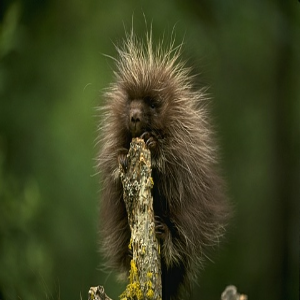

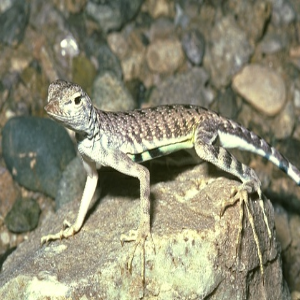

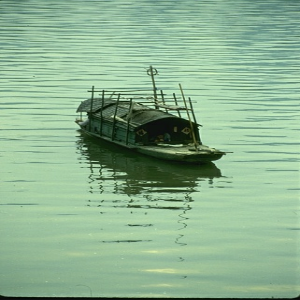

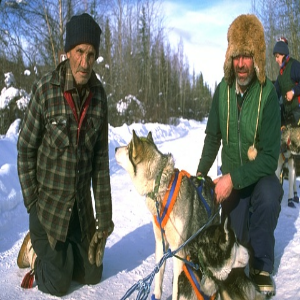

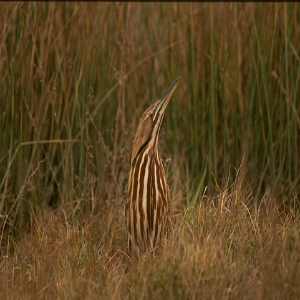

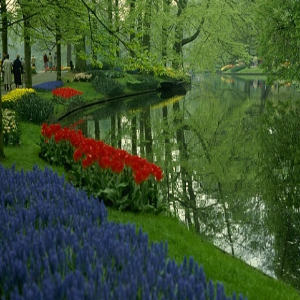

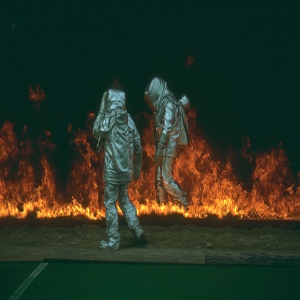

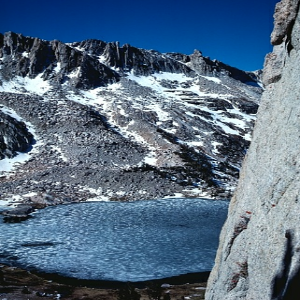

In [38]:
for batch in train_ds.take(1):
  for img in batch:
    display(array_to_img(img))

In [39]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

# Preprocesamiento de las imágenes

In [40]:
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

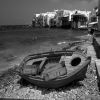

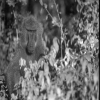

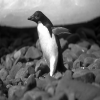

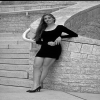

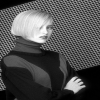

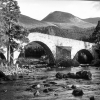

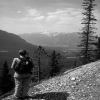

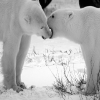

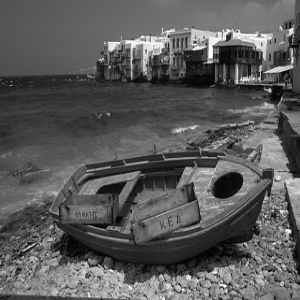

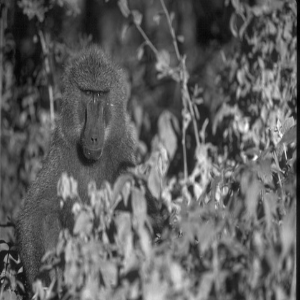

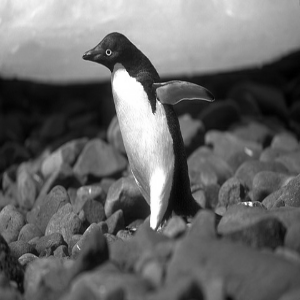

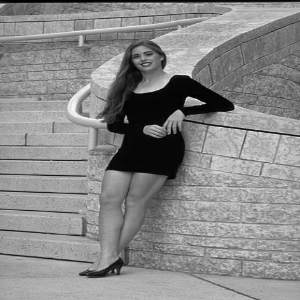

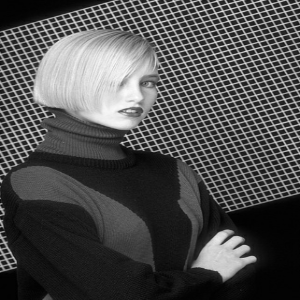

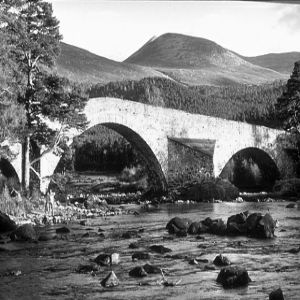

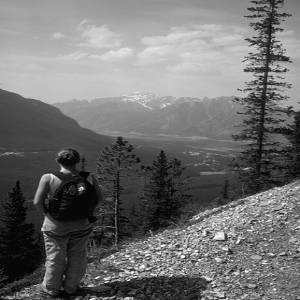

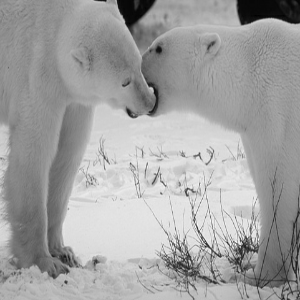

In [41]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

# Construcción del Modelo (Conv 2D Layers)

In [42]:
def get_model(upscale_factor=3, channels=1):
  conv_args = {
      "activation":"relu",
      "kernel_initializer":"Orthogonal",
      "padding":"same",
  }
  inputs = keras.Input(shape=(None, None, channels))
  x = layers.Conv2D(64, 5, **conv_args)(inputs)
  x = layers.Conv2D(64, 3, **conv_args)(x)
  x = layers.Conv2D(32, 3, **conv_args)(x)
  x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
  outputs = tf.nn.depth_to_space(x, upscale_factor)

  return keras.Model(inputs, outputs)

In [43]:
# Resultados en un simulador de tipo Monitor
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

def plot_results(img, prefix, title):
  """ Hacer zoom en una área en especial """
  img_array = img_to_array(img)
  img_array = img_array.astype("float32") / 255.0

  # Crear nueva figura en un subplot 111
  fig, ax = plt.subplots()
  im = ax.imshow(img_array[::-1], origin="lower")

  plt.title(title)
  axins = zoomed_inset_axes(ax, 2, loc=2)
  axins.imshow(img_array[::-1], origin="lower")

  x1, x2, y1, y2 = 200, 300, 100, 200
  # Limites en X
  axins.set_xlim(x1, x2)
  # Limites en y
  axins.set_ylim(y1, y2)

  plt.yticks(visible=False)
  plt.xticks(visible=False)

  # Crear una área para indicar
  mark_inset(ax, axins, loc1=1, loc2=3, fc="None", ec="red")
  plt.savefig(str(prefix) + "-" + title + ".png")
  plt.show()

def get_lowres_image(img, upscale_factor):
  """Regresa la imagen de baja resolución"""
  return img.resize(
      (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
      PIL.Image.BICUBIC,
  )

def upscale_image(model, img):
  """Predice la imagen"""
  ycbcr = img.convert("YCbCr")
  y, cb, cr = ycbcr.split()
  y = img_to_array(y)
  y = y.astype("float32") / 255.0

  input = np.expand_dims(y, axis=0)
  out = model.predict(input)

  out_img_y = out[0]
  out_img_y *= 255.0

  # Reconstrucción del espacio de color RGB

  out_img_y = out_img_y.clip(0, 255)
  out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
  out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
  out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
  out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
      "RGB"
  )
  return out_img

# Peak Signal to Noise Ration (PSNR)

* Calculará y mostrará la métrica

In [44]:
class ESPCNCallback(keras.callbacks.Callback):
  def __init__(self):
    super(ESPCNCallback, self).__init__()
    self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)
  
  # Guardar el PSNR en cada época
  def on_epoch_begin(self, epoch, logs=None):
    self.psnr = []
  
  def on_epoch_end(self, epoch, logs=None):
    print("Media PSNR de cada época: %.2f" % (np.mean(self.psnr)))
    if epoch % 20 == 0:
      prediction = upscale_image(self.model, self.test_img)
      plot_results(prediction, "epoch-" + str(epoch), "predicción")

  def on_test_batch_end(self, batch, logs=None):
    self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [46]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_32 (Conv2D)          (None, None, None, 64)    1664      
                                                                 
 conv2d_33 (Conv2D)          (None, None, None, 64)    36928     
                                                                 
 conv2d_34 (Conv2D)          (None, None, None, 32)    18464     
                                                                 
 conv2d_35 (Conv2D)          (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space_8 (TFO  (None, None, None, 1)    0         
 pLambda)                                                        
                                                           

# Entrenamiento

Epoch 1/100
Media PSNR de cada época: 21.47


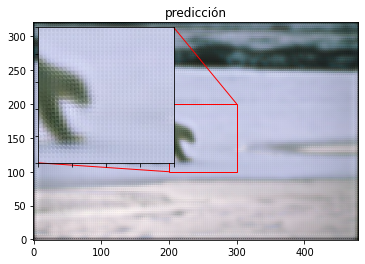

50/50 - 17s - loss: 0.0255 - val_loss: 0.0072 - 17s/epoch - 349ms/step
Epoch 2/100
Media PSNR de cada época: 23.19
50/50 - 3s - loss: 0.0062 - val_loss: 0.0046 - 3s/epoch - 57ms/step
Epoch 3/100
Media PSNR de cada época: 24.99
50/50 - 3s - loss: 0.0044 - val_loss: 0.0033 - 3s/epoch - 57ms/step
Epoch 4/100
Media PSNR de cada época: 25.97
50/50 - 3s - loss: 0.0034 - val_loss: 0.0028 - 3s/epoch - 55ms/step
Epoch 5/100
Media PSNR de cada época: 25.91
50/50 - 3s - loss: 0.0030 - val_loss: 0.0026 - 3s/epoch - 58ms/step
Epoch 6/100
Media PSNR de cada época: 26.18
50/50 - 3s - loss: 0.0030 - val_loss: 0.0025 - 3s/epoch - 60ms/step
Epoch 7/100
Media PSNR de cada época: 26.21
50/50 - 3s - loss: 0.0029 - val_loss: 0.0025 - 3s/epoch - 59ms/step
Epoch 8/100
Media PSNR de cada época: 26.20
50/50 - 3s - loss: 0.0028 - val_loss: 0.0025 - 3s/epoch - 56ms/step
Epoch 9/100
Media PSNR de cada época: 26.35
50/50 - 3s - loss: 0.0028 - val_loss: 0.0025 - 3s/epoch - 54ms/step
Epoch 10/100
Media PSNR de cada é

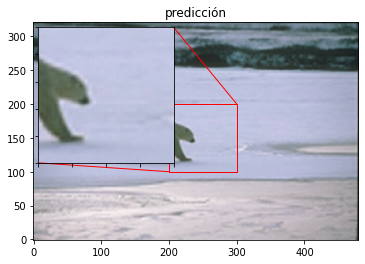

50/50 - 5s - loss: 0.0027 - val_loss: 0.0024 - 5s/epoch - 95ms/step
Epoch 22/100
Media PSNR de cada época: 26.20
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024 - 3s/epoch - 56ms/step
Epoch 23/100
Media PSNR de cada época: 26.48
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024 - 3s/epoch - 54ms/step
Epoch 24/100
Media PSNR de cada época: 26.63
50/50 - 3s - loss: 0.0027 - val_loss: 0.0024 - 3s/epoch - 56ms/step
Epoch 25/100
Media PSNR de cada época: 27.00
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 54ms/step
Epoch 26/100
Media PSNR de cada época: 26.29
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 56ms/step
Epoch 27/100
Media PSNR de cada época: 27.17
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 55ms/step
Epoch 28/100
Media PSNR de cada época: 26.40
50/50 - 3s - loss: 0.0026 - val_loss: 0.0024 - 3s/epoch - 58ms/step
Epoch 29/100
Media PSNR de cada época: 26.61
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 60ms/step
Epoch 30/100
Media PSNR de c

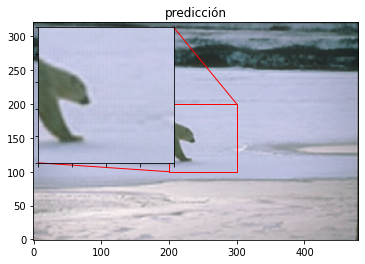

50/50 - 4s - loss: 0.0029 - val_loss: 0.0023 - 4s/epoch - 77ms/step
Epoch 42/100
Media PSNR de cada época: 26.66
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 56ms/step
Epoch 43/100
Media PSNR de cada época: 26.82
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 57ms/step
Epoch 44/100
Media PSNR de cada época: 26.80
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 56ms/step
Epoch 45/100
Media PSNR de cada época: 26.43
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 59ms/step
Epoch 46/100
Media PSNR de cada época: 26.22
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 55ms/step
Epoch 47/100
Media PSNR de cada época: 26.54
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 57ms/step
Epoch 48/100
Media PSNR de cada época: 26.31
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 61ms/step
Epoch 49/100
Media PSNR de cada época: 26.49
50/50 - 3s - loss: 0.0026 - val_loss: 0.0023 - 3s/epoch - 62ms/step
Epoch 50/100
Media PSNR de c

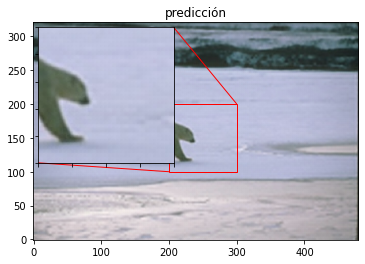

50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 49ms/step
Epoch 62/100
Media PSNR de cada época: 26.19
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 36ms/step
Epoch 63/100
Media PSNR de cada época: 26.34
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 36ms/step
Epoch 64/100
Media PSNR de cada época: 27.30
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 37ms/step
Epoch 65/100
Media PSNR de cada época: 26.86
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 43ms/step
Epoch 66/100
Media PSNR de cada época: 26.37
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 36ms/step
Epoch 67/100
Media PSNR de cada época: 26.06
50/50 - 2s - loss: 0.0025 - val_loss: 0.0026 - 2s/epoch - 36ms/step
Epoch 68/100
Media PSNR de cada época: 26.64
50/50 - 2s - loss: 0.0027 - val_loss: 0.0023 - 2s/epoch - 35ms/step
Epoch 69/100
Media PSNR de cada época: 26.42
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 45ms/step
Epoch 70/100
Media PSNR de c

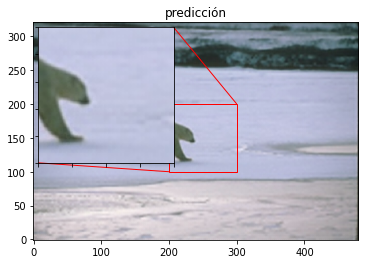

50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 49ms/step
Epoch 82/100
Media PSNR de cada época: 26.63
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 37ms/step
Epoch 83/100
Media PSNR de cada época: 26.82
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 42ms/step
Epoch 84/100
Media PSNR de cada época: 26.68
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 36ms/step
Epoch 85/100
Media PSNR de cada época: 26.82
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 42ms/step
Epoch 86/100
Media PSNR de cada época: 26.17
50/50 - 2s - loss: 0.0025 - val_loss: 0.0022 - 2s/epoch - 42ms/step
Epoch 87/100
Media PSNR de cada época: 26.45
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 36ms/step
Epoch 88/100
Media PSNR de cada época: 26.22
50/50 - 2s - loss: 0.0025 - val_loss: 0.0023 - 2s/epoch - 36ms/step
Epoch 89/100
Media PSNR de cada época: 26.24
50/50 - 2s - loss: 0.0026 - val_loss: 0.0024 - 2s/epoch - 36ms/step
Epoch 90/100
Media PSNR de c

In [48]:
epochs = 100
model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data = valid_ds, verbose=2
)

model.load_weights(checkpoint_filepath)

# Test

PSNR (Baja resolución y alta) es 28.1701
PSNR (Predicción y alta resolución) es 29.3078


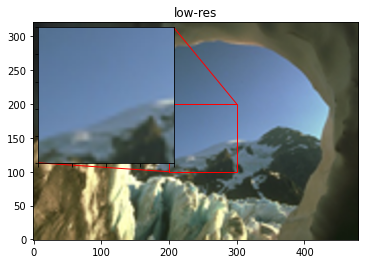

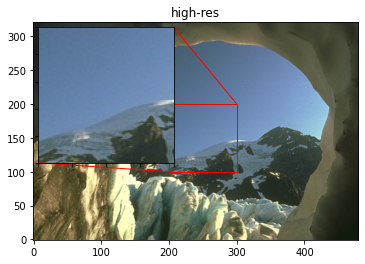

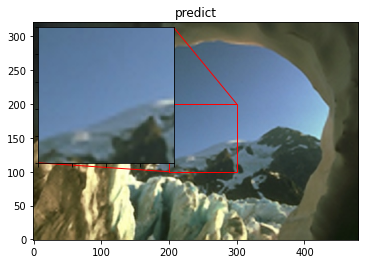

PSNR (Baja resolución y alta) es 29.3742
PSNR (Predicción y alta resolución) es 30.4266


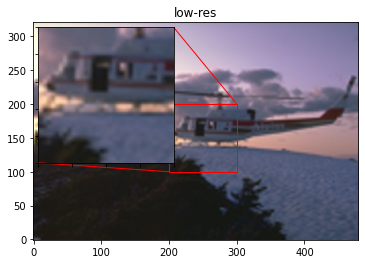

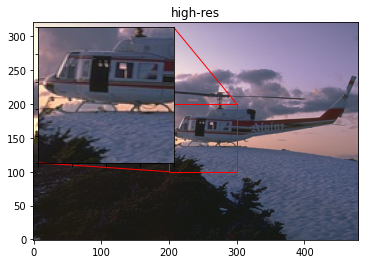

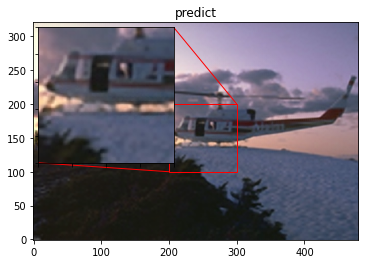

PSNR (Baja resolución y alta) es 24.7788
PSNR (Predicción y alta resolución) es 27.1868


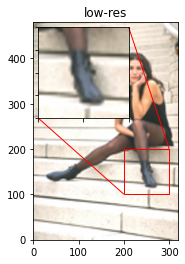

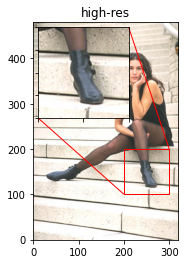

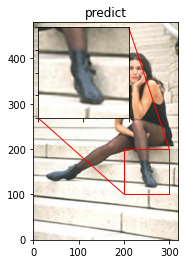

PSNR (Baja resolución y alta) es 23.5685
PSNR (Predicción y alta resolución) es 23.6633


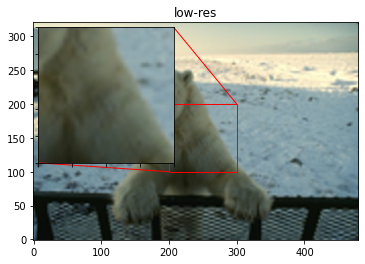

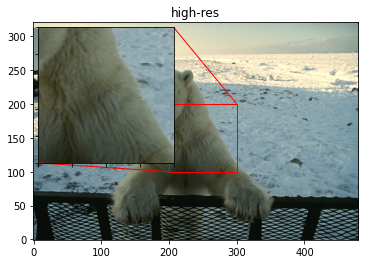

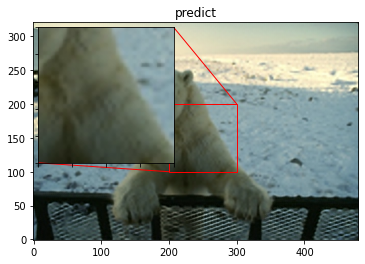

PSNR (Baja resolución y alta) es 31.0233
PSNR (Predicción y alta resolución) es 31.4764


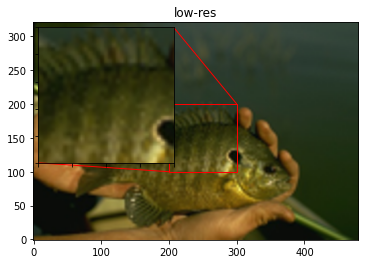

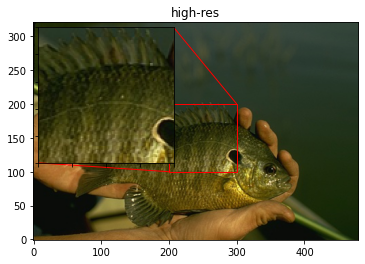

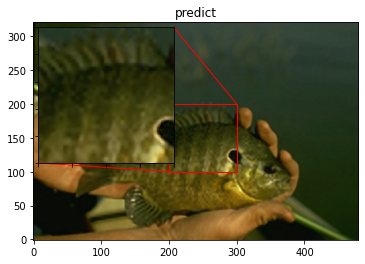

In [51]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[65:70]):
  img = load_img(test_img_path)
  lowres_input = get_lowres_image(img, upscale_factor)
  w = lowres_input.size[0] * upscale_factor
  h = lowres_input.size[1] * upscale_factor
  highres_img = img.resize((w, h))
  prediction = upscale_image(model, lowres_input)
  lowres_img = lowres_input.resize((w, h))
  lowres_img_arr = img_to_array(lowres_img)
  highres_img_arr = img_to_array(highres_img)
  predict_img_arr = img_to_array(prediction)
  bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
  test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

  total_bicubic_psnr += bicubic_psnr
  total_test_psnr += test_psnr

  print("PSNR (Baja resolución y alta) es %.4f" % bicubic_psnr)
  print("PSNR (Predicción y alta resolución) es %.4f" % test_psnr)
  plot_results(lowres_img, index, "low-res")
  plot_results(highres_img, index, "high-res")
  plot_results(prediction, index, "predict")